# Linear & non-linear limit of diffusion under OU policy
## TOC:
* [Comparison of analytical results and numerics of OU process in linear limit](#first-bullet)
* [Computing diffusion of the agent in the non-linear limit](#second-bullet)

In [39]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import jax.numpy as jnp
import jax
from jax import random
from jax import jit
from jax import vmap
from jax import lax
from jax.tree_util import register_pytree_node

import time
import random as rm
import pandas as pd

In [40]:
colors = {
    "gray": {
        0: "#f8f9fa",
        1: "#f1f3f5",
        2: "#e9ecef",
        3: "#dee2e6",
        4: "#ced4da",
        5: "#adb5bd",
        6: "#868e96",
        7: "#495057",
        8: "#343a40",
        9: "#212529",
    },
    "red": {
        0: "#fff5f5",
        1: "#ffe3e3",
        2: "#ffc9c9",
        3: "#ffa8a8",
        4: "#ff8787",
        5: "#ff6b6b",
        6: "#fa5252",
        7: "#f03e3e",
        8: "#e03131",
        9: "#c92a2a",
    },
    "pink": {
        0: "#fff0f6",
        1: "#ffdeeb",
        2: "#fcc2d7",
        3: "#faa2c1",
        4: "#f783ac",
        5: "#f06595",
        6: "#e64980",
        7: "#d6336c",
        8: "#c2255c",
        9: "#a61e4d",
    },
    "grape": {
        0: "#f8f0fc",
        1: "#f3d9fa",
        2: "#eebefa",
        3: "#e599f7",
        4: "#da77f2",
        5: "#cc5de8",
        6: "#be4bdb",
        7: "#ae3ec9",
        8: "#9c36b5",
        9: "#862e9c",
    },
    "violet": {
        0: "#f3f0ff",
        1: "#e5dbff",
        2: "#d0bfff",
        3: "#b197fc",
        4: "#9775fa",
        5: "#845ef7",
        6: "#7950f2",
        7: "#7048e8",
        8: "#6741d9",
        9: "#5f3dc4",
    },
    "indigo": {
        0: "#edf2ff",
        1: "#dbe4ff",
        2: "#bac8ff",
        3: "#91a7ff",
        4: "#748ffc",
        5: "#5c7cfa",
        6: "#4c6ef5",
        7: "#4263eb",
        8: "#3b5bdb",
        9: "#364fc7",
    },
    "blue": {
        0: "#e7f5ff",
        1: "#d0ebff",
        2: "#a5d8ff",
        3: "#74c0fc",
        4: "#4dabf7",
        5: "#339af0",
        6: "#228be6",
        7: "#1c7ed6",
        8: "#1971c2",
        9: "#1864ab",
    },
    "cyan": {
        0: "#e3fafc",
        1: "#c5f6fa",
        2: "#99e9f2",
        3: "#66d9e8",
        4: "#3bc9db",
        5: "#22b8cf",
        6: "#15aabf",
        7: "#1098ad",
        8: "#0c8599",
        9: "#0b7285",
    },
    "teal": {
        0: "#e6fcf5",
        1: "#c3fae8",
        2: "#96f2d7",
        3: "#63e6be",
        4: "#38d9a9",
        5: "#20c997",
        6: "#12b886",
        7: "#0ca678",
        8: "#099268",
        9: "#087f5b",
    },
    "green": {
        0: "#ebfbee",
        1: "#d3f9d8",
        2: "#b2f2bb",
        3: "#8ce99a",
        4: "#69db7c",
        5: "#51cf66",
        6: "#40c057",
        7: "#37b24d",
        8: "#2f9e44",
        9: "#2b8a3e",
    },
    "lime": {
        0: "#f4fce3",
        1: "#e9fac8",
        2: "#d8f5a2",
        3: "#c0eb75",
        4: "#a9e34b",
        5: "#94d82d",
        6: "#82c91e",
        7: "#74b816",
        8: "#66a80f",
        9: "#5c940d",
    },
    "yellow": {
        0: "#fff9db",
        1: "#fff3bf",
        2: "#ffec99",
        3: "#ffe066",
        4: "#ffd43b",
        5: "#fcc419",
        6: "#fab005",
        7: "#f59f00",
        8: "#f08c00",
        9: "#e67700",
    },
    "orange": {
        0: "#fff4e6",
        1: "#ffe8cc",
        2: "#ffd8a8",
        3: "#ffc078",
        4: "#ffa94d",
        5: "#ff922b",
        6: "#fd7e14",
        7: "#f76707",
        8: "#e8590c",
        9: "#d9480f",
    },
    "mixed": {
        0: "#880e4f",
        1: "#1a237e",
        2: "#e65100",
        3: "#004d40",
        4: "#c92a2a",
    },
}

Dynamics of an agent whose orientation is described by the Ornstein-Uhlenbeck process is given by

$
\dot{\theta}(t) = - \alpha \theta(t) + \sqrt{2D} \eta(t)
$

$
\langle \eta(t) \eta(t') \rangle = \delta(t-t')
$

In [41]:
# Parameters in the model
class params():
    def __init__(self) -> None:
        super().__init__()
        self.nSteps = 800
        self.nEpchs = 500
        
        self.dt = 1e-2
        self.l = 5e-3
        self.vo = self.l/self.dt
        self.alpha = 50
        self.diff = 10/jnp.pi
        
        self.rInit = jnp.array([0.0, 0.0])
        self.thInit = 0.

In [42]:
# Single step dynamics of the agent
class agent():
    def __init__(self, r, thet, rng):
        super().__init__()
        self.r = r
        self.thet = thet
        self.rng = rng
    
    @jit
    def stepFwd(self, dt, l, diff, alpha):
        drng = random.split(self.rng)[0]
        self.r += l*jnp.array([jnp.cos(self.thet), jnp.sin(self.thet)])
        # self.thet = self.thet*(1-p.nu*p.dt) + p.nu*p.dt*p.tgtPhi + np.sqrt(2*p.diff*p.dt)*np.random.normal()
        self.thet = self.thet*(1-alpha*dt) + jnp.sqrt(2*diff*dt)*random.normal(drng)
        return agent(self.r, self.thet, drng)
    
register_pytree_node(agent,
                     lambda x: ((x.r[0], x.r[1], x.thet, x.rng), None),
                     lambda _, tup: agent(jnp.array([tup[0], tup[1]]), tup[2], tup[3]))

 ## <a class="anchor" id="first-bullet">Single epoch of agent dynamics</a>

--- 0.39942097663879395 seconds ---


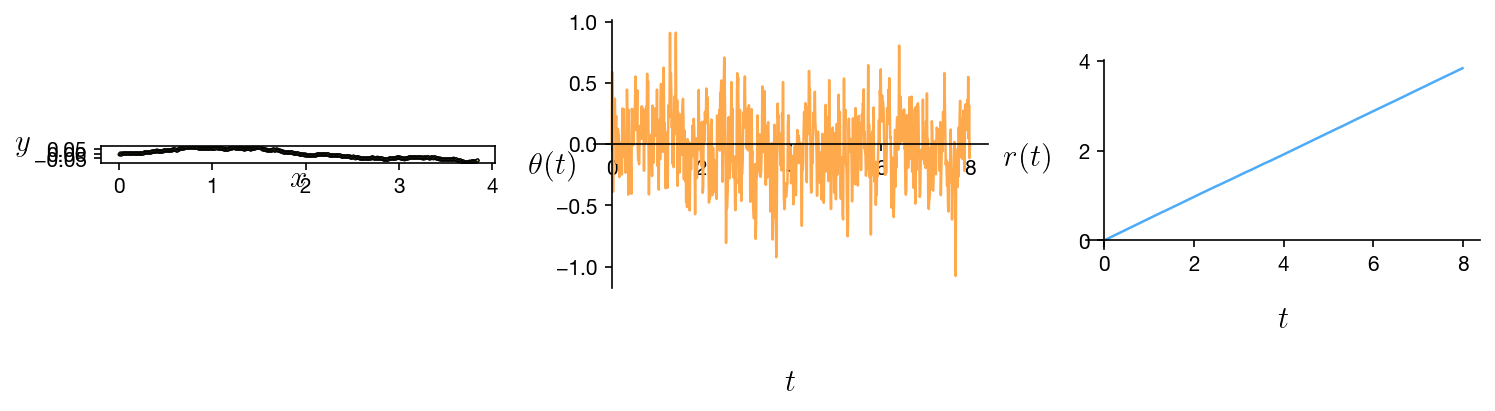

In [80]:
# Single epoch of agent dynamics for p.nSteps
rng = random.PRNGKey(rm.randint(0,10000))
p = params()
ag = agent(p.rInit, p.thInit, rng)
start_time = time.time()
rxFull = np.array(p.rInit[0])
ryFull = np.array(p.rInit[1])
thetFull = np.array(p.thInit)

dfx = pd.DataFrame()
dfy = pd.DataFrame()

for i in range(p.nSteps):
    ag = ag.stepFwd(p.dt, p.l, p.diff, p.alpha)
    rxFull = np.vstack((rxFull, np.array(ag.r[0])))
    ryFull = np.vstack((ryFull, np.array(ag.r[1])))
    thetFull = np.vstack((thetFull, np.array(ag.thet)))
    # dfx[i] = rxFull.tolist()
    # dfy[i] = ryFull.tolist()
print("--- %s seconds ---" % (time.time() - start_time))

dfx = pd.DataFrame(rxFull)
dfy = pd.DataFrame(ryFull)

mpl.rcParams.update(mpl.rcParamsDefault)
plt.rc("font", family="Helvetica Neue")
plt.rc("xtick", labelsize="medium")

linewidth = 1.2
linestyle = "-"
label_size = 15
color = '#8dc63f'

fig = plt.figure(figsize=(10, 3), dpi=150)

nrows, ncols = 2, 2
gspec = gridspec.GridSpec(
    ncols=ncols, nrows=nrows, figure=fig, width_ratios=[1, 1], height_ratios=[1, 1]
)

nRow = 1
nCol = 3
ax1 = plt.subplot(nRow, nCol, 1, aspect=1)
ax1.scatter(rxFull, ryFull,
            s=2,
            color=color,
            edgecolors='k',
            linewidth=0.5,
            zorder=-1)
ax1.set_xlabel(r'$x$',usetex=True, fontsize=label_size)
ax1.set_ylabel(r'$y$',usetex=True,rotation=0, fontsize=label_size)

ax1.xaxis.set_label_coords(0.5,-0.1)
ax1.yaxis.set_label_coords(-0.2,0.4)


ax2 = plt.subplot(nRow, nCol, 2)
t = jnp.arange(p.nSteps)*p.dt
# ax2.plot(t, np.mod(thetFull[:-1],2*np.pi),
ax2.plot(t, thetFull[:-1],
        color=colors['orange'][4],
        clip_on=False,
        linewidth=linewidth,
        linestyle=linestyle,)
ax2.set_xlabel(r'$t$',usetex=True, fontsize=label_size)
ax2.set_ylabel(r'$\theta(t)$',usetex=True,rotation=0, fontsize=label_size)
# ax2.set_ylim([0.,2*np.pi])

ax2.xaxis.set_label_coords(0.5,-0.3)
ax2.yaxis.set_label_coords(-0.1,0.4)

ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.spines["left"].set_position(("data", 0))
ax2.spines["bottom"].set_position(("data", 0))

ax3 = plt.subplot(nRow, nCol, 3, aspect=1)
ax3.plot(t, np.sqrt(rxFull[:-1]**2 + ryFull[:-1]**2),
        color=colors['blue'][4],
        clip_on=False,
        linewidth=linewidth,
        linestyle=linestyle,)
ax3.set_xlabel(r'$t$',usetex=True, fontsize=label_size)
ax3.set_ylabel(r'$r(t)$',usetex=True,rotation=0, fontsize=label_size)
# ax3.set_ylim([0.,2*np.pi])

ax3.xaxis.set_label_coords(0.5,-0.3)
ax3.yaxis.set_label_coords(-0.15,0.4)

ax3.spines["right"].set_visible(False)
ax3.spines["top"].set_visible(False)
ax3.spines["left"].set_position(("data", 0))
ax3.spines["bottom"].set_position(("data", 0))


plt.tight_layout()
plt.show()

In [81]:
dfx

,0
0,0.000000
1,0.005000
2,0.009152
3,0.013897
4,0.018526
...,...
796,3.823797
797,3.828792
798,3.833539
799,3.838507


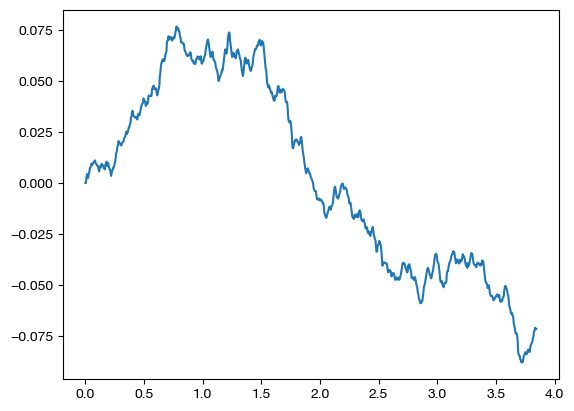

In [82]:
plt.plot(dfx, dfy)
plt.show()

 ## <a class="anchor" id="second-bullet">Several epochs of dynamics</a>

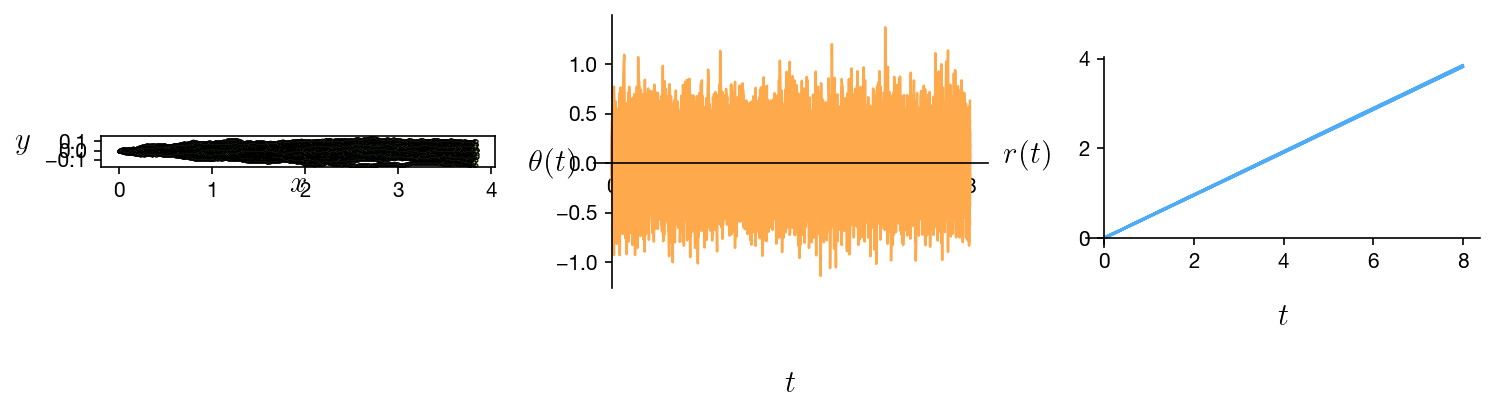

In [116]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rc("font", family="Helvetica Neue")
plt.rc("xtick", labelsize="medium")

linewidth = 1.2
linestyle = "-"
label_size = 15
color = '#8dc63f'

fig = plt.figure(figsize=(10, 3), dpi=150)

nrows, ncols = 2, 2
gspec = gridspec.GridSpec(
ncols=ncols, nrows=nrows, figure=fig, width_ratios=[1, 1], height_ratios=[1, 1]
)

p = params()
dfx = pd.DataFrame()
dfy = pd.DataFrame()
# for ind in np.arange(p.nEpchs):
for ind in np.arange(30):
    rng = random.PRNGKey(rm.randint(0,10000))
    ag = agent(p.rInit, p.thInit, rng)
    rxFull = np.array(p.rInit[0])
    ryFull = np.array(p.rInit[1])
    thetFull = np.array(p.thInit)
    for i in range(p.nSteps):
        ag = ag.stepFwd(p.dt, p.l, p.diff, p.alpha)
        rxFull = np.vstack((rxFull, ag.r[0]))
        ryFull = np.vstack((ryFull, np.array(ag.r[1])))
        thetFull = np.vstack((thetFull, np.array(ag.thet)))
    dfx[ind] = rxFull.flatten().tolist()
    dfy[ind] = ryFull.flatten().tolist()
    nRow = 1
    nCol = 3
    ax1 = plt.subplot(nRow, nCol, 1, aspect=1)

    ax1.scatter(rxFull, ryFull,
                s=2,
                color=color,
                edgecolors='k',
                linewidth=0.5,
                zorder=-1)
    ax1.set_xlabel(r'$x$',usetex=True, fontsize=label_size)
    ax1.set_ylabel(r'$y$',usetex=True,rotation=0, fontsize=label_size)

    ax1.xaxis.set_label_coords(0.5,-0.1)
    ax1.yaxis.set_label_coords(-0.2,0.4)


    ax2 = plt.subplot(nRow, nCol, 2)
    t = jnp.arange(p.nSteps)*p.dt
    ax2.plot(t, thetFull[:-1],
            color=colors['orange'][4],
            clip_on=False,
            linewidth=linewidth,
            linestyle=linestyle,)
    ax2.set_xlabel(r'$t$',usetex=True, fontsize=label_size)
    ax2.set_ylabel(r'$\theta(t)$',usetex=True,rotation=0, fontsize=label_size)

    ax2.xaxis.set_label_coords(0.5,-0.3)
    ax2.yaxis.set_label_coords(-0.1,0.4)

    ax2.spines["right"].set_visible(False)
    ax2.spines["top"].set_visible(False)
    ax2.spines["left"].set_position(("data", 0))
    ax2.spines["bottom"].set_position(("data", 0))

    ax3 = plt.subplot(nRow, nCol, 3, aspect=1)
    ax3.plot(t, np.sqrt(rxFull[:-1]**2 + ryFull[:-1]**2),
            color=colors['blue'][4],
            clip_on=False,
            linewidth=linewidth,
            linestyle=linestyle,)
    ax3.set_xlabel(r'$t$',usetex=True, fontsize=label_size)
    ax3.set_ylabel(r'$r(t)$',usetex=True,rotation=0, fontsize=label_size)
    ax3.xaxis.set_label_coords(0.5,-0.3)
    ax3.yaxis.set_label_coords(-0.15,0.4)

    ax3.spines["right"].set_visible(False)
    ax3.spines["top"].set_visible(False)
    ax3.spines["left"].set_position(("data", 0))
    ax3.spines["bottom"].set_position(("data", 0))


plt.tight_layout()
plt.show()

In [117]:
dfx

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,...,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000
2,0.009861,0.009954,0.009998,0.009803,0.009856,0.009975,0.010000,0.009967,0.009878,0.010000,...,0.009984,0.009983,0.009753,0.009525,0.009949,0.009841,0.009571,0.009992,0.009966,0.009555
3,0.014426,0.014912,0.014997,0.014783,0.014808,0.014588,0.014882,0.014882,0.014865,0.014394,...,0.014948,0.014677,0.014497,0.014455,0.014744,0.014841,0.014095,0.014960,0.014587,0.014553
4,0.019078,0.019356,0.019867,0.019612,0.019799,0.019438,0.019112,0.019746,0.019854,0.018722,...,0.019879,0.019674,0.018851,0.019052,0.019731,0.019797,0.019004,0.019955,0.019293,0.019381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,3.826327,3.836154,3.806613,3.804437,3.812361,3.814518,3.807126,3.809317,3.808773,3.797502,...,3.819044,3.818617,3.806406,3.807277,3.812579,3.798990,3.801172,3.832383,3.821333,3.823812
797,3.831318,3.841153,3.811594,3.809197,3.816856,3.819475,3.811909,3.814306,3.813750,3.802217,...,3.823874,3.823522,3.810828,3.812102,3.817534,3.803492,3.806158,3.837340,3.826329,3.828763
798,3.836092,3.846153,3.816546,3.814176,3.821484,3.824468,3.816906,3.818880,3.818558,3.806822,...,3.828793,3.828442,3.814193,3.817076,3.822527,3.808358,3.810916,3.841549,3.830867,3.833762
799,3.841071,3.851142,3.821525,3.818723,3.826089,3.829412,3.821885,3.823487,3.823373,3.811730,...,3.833791,3.833139,3.819111,3.821839,3.827433,3.813309,3.815392,3.845988,3.835017,3.838759


In [119]:
dfy

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,-0.001172,0.000676,0.000144,-0.001388,0.001191,0.000502,0.000060,-0.000572,-0.001098,-0.000006,...,-0.000394,0.000407,0.001551,0.002126,-0.000715,-0.001251,0.002027,0.000278,0.000578,0.002063
3,-0.003210,0.000028,0.000249,-0.000936,0.001883,-0.001426,0.001137,-0.001489,-0.001454,0.002381,...,0.000212,0.002132,-0.000029,0.002965,-0.002130,-0.001261,0.004156,-0.000289,-0.001332,0.001950
4,-0.005043,0.002319,-0.000881,0.000359,0.002180,-0.002641,0.003803,-0.002651,-0.001125,0.004884,...,-0.000614,0.001976,-0.002486,0.004930,-0.002494,-0.000603,0.005106,-0.000518,-0.003021,0.003251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,0.001137,0.002447,-0.104689,-0.001041,-0.102720,0.063776,0.027051,0.097881,-0.038178,-0.001405,...,-0.099055,0.074562,-0.037665,0.074233,0.043217,-0.133770,-0.024026,-0.070890,-0.000798,0.100200
797,0.000833,0.002519,-0.104255,-0.002572,-0.100530,0.064431,0.025595,0.098213,-0.038662,-0.003068,...,-0.097764,0.073589,-0.039998,0.075545,0.042546,-0.131595,-0.023648,-0.070236,-0.000594,0.100892
798,0.002318,0.002599,-0.104948,-0.002118,-0.098636,0.064686,0.025747,0.096194,-0.040034,-0.005017,...,-0.096864,0.072697,-0.043696,0.075035,0.042809,-0.130446,-0.022111,-0.067537,0.001505,0.101018
799,0.002779,0.002924,-0.104490,-0.004199,-0.096690,0.063936,0.026210,0.094251,-0.041379,-0.005973,...,-0.096996,0.070986,-0.044602,0.073514,0.043771,-0.129750,-0.024339,-0.065236,-0.001284,0.100848


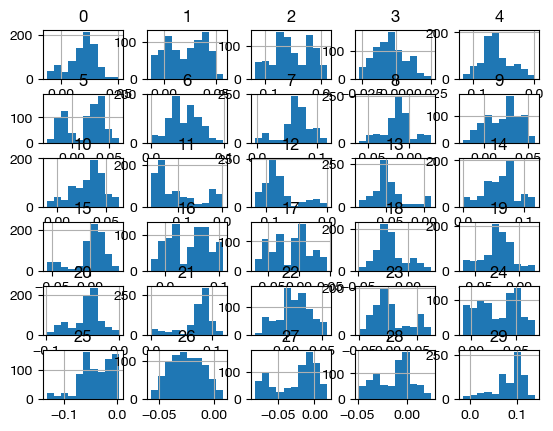

In [134]:
dfy.hist(bins=10)
plt.show()